# **Visión por Computadora I   -   Trabajo Práctico 2**
## Gustavo Uñapillco      a1624

In [1]:
#Importación de liberías
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
#from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from PIL import Image
import time
import copy
import io

## **Parte 1**

### **Enunciado y codificación de funciones**

>Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper"ImageSharpnessMeasureforBlurredImagesin FrequencyDomain“ y realizar tres experimentos:
                >
        >   1.1. Medición sobre todo el frame.
        >
        >   1.2. Medición sobre una ROI ubicada en el centro del frame. Area de la ROI = 5 o 10% del area total del frame.
        >
        >   1.3. Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores arbitrarios, probar con varios valores 3x3, 7x5, etc… (al menos 3)
>
>Para cada experimento se debe presentar :
> - Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuando el algoritmo detecto el punto de máximo enfoque.
> - Video con la ROI o matriz, graficada en rojo y superpuesta al video original para los frames que no están en foco y verde para los frames donde se detecta la condición de máximo enfoque.

In [2]:
#Función de algoritmo de paper
def sharpness_measure(frames, M_alto, N_ancho):
    """Step 1: Compute F which is the Fourier Transform representation of image I
        F_ls 
        Tipo: lista de 171 elementos
        Elemento: Arrays de (360,640,3)
    """
    F_ls = []

    """Step 2: Find Fc which is obtained by shifting the origin of F to centre.
        Fc_ls
        Tipo: lista de 171 elementos
        Elemento: Arrays de (360,640,3)
    """
    Fc_ls = []

    """Step 3: Calculate AF = abs (Fc) where AF is the absolute value of the centered Fourier transform of image I.
        AF_ls
        Tipo: lista de 171 elementos
        Elemento: Arrays de (360,640,3)   
        """
    AF_ls = []

    """Step 4: Calculate M = max (AF) where M is the maximum value of the frequency component in F.
        M_ls
        Tipo: lista de 171 elementos
        Elemento: numpy.float64   
    """
    M_ls = []

    """Step 5: Calculate TH = the total number of pixels in F whose pixel value > thres, where thres = M/1000.
        TH_ls
        Tipo: lista de 171 elementos
        Elemento: numpy.float64  
    """
    TH_ls=[]
    counter=np.zeros(len(frames))

    for i in range(len(frames)) :
        #Paso 1
        F_ls.append(np.fft.fft2(frames[i]))
        #Paso 2
        Fc_ls.append(np.fft.fftshift(F_ls[i]))
        #Paso 3
        #AF_ls.append(20*np.log(np.abs(Fcs_ls[i])))
        AF_ls.append(np.abs(Fc_ls[i]))      #Valor absoluto
        #Paso 4|
        M_ls.append(np.max(AF_ls[i]))

    for i in range(len(frames)) :
        #Paso 5
        array = F_ls[i]
        thres = M_ls[i]/1000 
        counter[i] += np.sum(array > thres)
        TH_ls.append(counter[i])

    #Step 6: Calculate Image Quality measure (FM) from equation (1).
    M_N = M_alto*N_ancho
    FM_ls = []
    for i in range(len(frames)):
        FM_ls.append(TH_ls[i]/M_N)
    
    return FM_ls 

In [3]:
#Función para normalizar el color
def matriz_color(valor, minimo, maximo):

    # Normalizamos el valor entre 0 y 1
    valor_normalizado = (valor - minimo) / (maximo - minimo)
    
    # Aseguramos que el valor esté entre 0 y 1
    valor_normalizado = max(0, min(1, valor_normalizado))
    
    # Interpolamos entre rojo (0, 0, 255) y verde (0, 255, 0)
    rojo = int((1 - valor_normalizado) * 255)  # Disminuye de 255 a 0
    verde = int(valor_normalizado * 255)       # Aumenta de 0 a 255
    azul = 0  # Siempre azul es 0 en este caso (ya que estamos interpolando entre rojo y verde)
    
    return (azul, verde, rojo)  # Formato BGR para OpenCV

In [4]:
#Función para mostrar imagenes
def mostrar_imagen(imagen, titulo=''):
    plt.figure(figsize=(10, 6))
    plt.imshow(cv.cvtColor(imagen, cv.COLOR_BGR2RGB))
    plt.title(titulo)
    plt.axis('off')
    plt.show()


In [5]:
# Abre el video
video_path = 'focus_video.mov'
capture = cv.VideoCapture(video_path)


In [6]:
#Análisis de frames
frames_ls = []
cantidad_frames = int(capture.get(cv.CAP_PROP_FRAME_COUNT))

if not capture.isOpened():
    print("Error al abrir el archivo de video")
else:
    for i in range(cantidad_frames) :
        ret, frame = capture.read()
        if ret:
            frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
            frames_ls.append(frame)
        else:
            break

# Obtén la tasa de cuadros (frame rate) del video
fps_frames = int(capture.get(cv.CAP_PROP_FPS))
frame_alto = int(capture.get(cv.CAP_PROP_FRAME_HEIGHT)) #Filas
frame_ancho = int(capture.get(cv.CAP_PROP_FRAME_WIDTH)) #Columnas
pix_frame=frame_alto*frame_ancho
capture.release()
cv.destroyAllWindows()

frames_for_roi_ls = copy.deepcopy(frames_ls)
frames_for_matriz_ls=copy.deepcopy(frames_ls)

In [7]:
#Información de frames
print(f'Cantidad de frames: {cantidad_frames}')
print(f'Dimensión de cada frame (Alto, Ancho) ó (Fila, Columna): ({frame_alto},{frame_ancho})')
print(f'Cantidad de pixeles por frame:', pix_frame)
print(f'Frames por segundo (fps): {fps_frames}')

Cantidad de frames: 171
Dimensión de cada frame (Alto, Ancho) ó (Fila, Columna): (360,640)
Cantidad de pixeles por frame: 230400
Frames por segundo (fps): 29


In [8]:
#Función para plotear
def FM_scatter_plot(frames, title = 'Calidad de imagen', color='b'):
    dpi=100
    x = list(range(len(frames)))  # Índices en el eje X (de 0 a 170)
    y = frames  # Valores en el eje Y
    plt.figure(figsize=(frame_ancho/dpi, frame_alto/dpi), dpi=dpi)
    # Crear el gráfico de líneas
    plt.plot(x, y, color, marker='.', linestyle='-')
    plt.xticks(np.arange(0, len(frames), step=10))
    # Añadir títulos y etiquetas
    plt.title(title)
    plt.xlabel('Frame #')
    plt.ylabel('Calidad')


    plt.tight_layout(pad=0)

    # Mostrar el gráfico
    plt.show()

In [9]:
def marker_size(valor, min_input=40, max_input=360, min_output=0.1, max_output=3):
    # Aplicar la fórmula de normalización
    normalizado = ((valor - min_input) / (max_input - min_input)) * (max_output - min_output) + min_output
    return normalizado


In [10]:
#Función para generar scatter plot para video
def gen_frames_video(frames, alto=frame_alto, ancho=frame_ancho, title = 'Calidad de imagen'):
    frames_video = []
    dpi=100
    x = list(range(len(frames)))  # Índices en el eje X (de 0 a 170)
    y = frames  # Valores en el eje Y
    
    # Crear los frames acumulativos y guardarlos en la lista
    for i in range(1, len(x) + 1):
        fig=plt.figure(figsize=(ancho/dpi, alto/dpi), dpi=dpi)
        plt.plot(x[:i], y[:i], marker='.', linestyle='-', markersize=marker_size(alto) , color='b',linewidth=1)
        plt.title(title, fontsize = alto//20)
        plt.xlabel("Frame #", fontsize = alto//20)
        plt.ylabel("Calidad", fontsize = alto//20)
        plt.xlim(0, 171)  # Fijar los límites del eje x
        plt.ylim(min(y), max(y))  # Fijar los límites del eje y para que no cambien
        # Ajustar el tamaño de los ticks de los ejes
        plt.tick_params(axis='both', which='major', labelsize=alto//25)
        # Remover espacios extra en los bordes para mantener las dimensiones exactas
        plt.tight_layout(pad=0.5)

        # Guardar la imagen en un buffer en lugar de en un archivo
        buf = io.BytesIO()
        plt.savefig(buf, format='png')  # Guardar en formato PNG en el buffer
        buf.seek(0)  # Mover el cursor al principio del buffer
        
        # Convertir la imagen en formato PIL y luego a un numpy array
        img = Image.open(buf)
        
        # Redimensionar la imagen para asegurar las dimensiones alto x ancho
        img = img.resize((ancho, alto))  # Redimensionar al tamaño deseado
          
        
        img_array = np.array(img)  # Convertir la imagen PIL a numpy array

        # Eliminar el canal alfa si existe
        if img_array.shape[2] == 4:  # Verificar si hay un canal alfa
            img_array = img_array[:, :, :3]  # Mantener solo los primeros tres canales (RGB)

        # Almacenar el contenido del buffer en la lista de frames
        frames_video.append(img_array)  # Guardar el contenido de la imagen como bytes
        
        # Limpiar el gráfico para el siguiente frame
        plt.clf()
        plt.close(fig)  # Cerrar la figura para liberar memoria
    return frames_video

In [11]:
#Función para concatenar dos imagenes 
def concatenar_imagenes (frame_1, frame_2):

    img_concatenada=[]
    for i in range (len(frame_1)):
        imagen_combinada = np.hstack((frame_1[i], frame_2[i]))
        img_concatenada.append(imagen_combinada)
    return img_concatenada

In [12]:
def crear_video (frames_video, alto_video , ancho_video,title='video'):#Crear video con los frames 
    output_video = cv.VideoWriter(f'{title}.mov', cv.VideoWriter_fourcc(*'AVC1'), fps_frames, (ancho_video, alto_video))
    # Escribir cada frame en el video
    for frame in frames_video:
        frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        output_video.write(frame)
    output_video.release()

### **1.1 Medición sobre todo el frame**

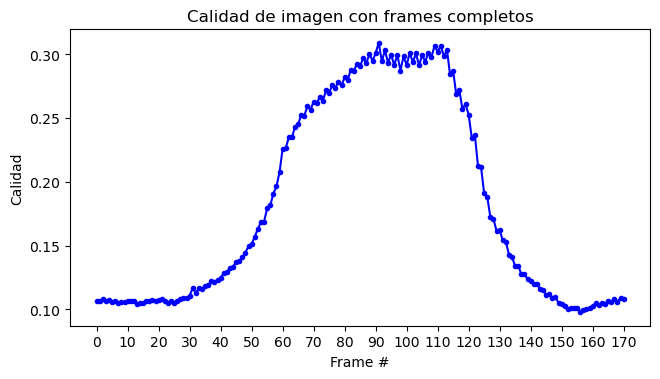

In [13]:
#Con frames completos
FM_frames_ls = sharpness_measure(frames_ls, frame_alto, frame_ancho)
#print(FM_frames_ls)
FM_scatter_plot(FM_frames_ls, 'Calidad de imagen con frames completos')


In [63]:
frames_video_completo = gen_frames_video(FM_frames_ls)

In [64]:
frames_para_video_completo = concatenar_imagenes(frames_ls, frames_video_completo)

In [65]:
crear_video (frames_para_video_completo, frames_para_video_completo[0].shape[0], frames_para_video_completo[0].shape[1],'Video_frame_completo')

### **1.2 Medición sobre ROI**

In [66]:
#Función para crear el ROI
def frame_roi (porcentaje, frame):        
    
    proporcion = frame_alto/frame_ancho
    pix_frame = frame_alto*frame_ancho
    
    #print('alto_frame: ', frame_alto)
    #print('ancho_frame: ', frame_ancho)

    
    #print('pix_frame: ', pix_frame)
    #Calculamos el ancho y el alto del ROI
    pix_roi = pix_frame*(porcentaje/100)
    #print('pix_roi: ', pix_roi)
    ancho_roi=int(np.ceil(np.sqrt(pix_roi/proporcion)))
    alto_roi = int(np.ceil(proporcion*ancho_roi))
    #print('ancho_roi: ', ancho_roi)
    #print('alto_roi: ', alto_roi)
    #Buscamos el punto central del frame
    x_centro_frame = frame_ancho//2  
    y_centro_frame = frame_alto//2   

    #Calculamos la mitad de cada lado roi
    dif_ancho_roi = int(ancho_roi//2)
    dif_alto_roi = int(alto_roi//2)
   
    x_inicio = x_centro_frame - dif_ancho_roi
    x_final = x_centro_frame + dif_ancho_roi
    y_inicio = y_centro_frame - dif_alto_roi
    y_final = y_centro_frame + dif_alto_roi
    #print(x_inicio, x_final, y_inicio, y_final)

    roi = frame[y_inicio:y_final, x_inicio:x_final]
    return roi, alto_roi, ancho_roi

In [67]:
#Función para enlistar los frames
def roi_ls (roi_porcentaje):
    frame_roi_ls = []
    for i in range(cantidad_frames):
        frame_reducido, alto_roi, ancho_roi = frame_roi (roi_porcentaje, frames_for_roi_ls[i])      
        frame_roi_ls.append(frame_reducido)
    return frame_roi_ls, alto_roi, ancho_roi

#### ROI 5%

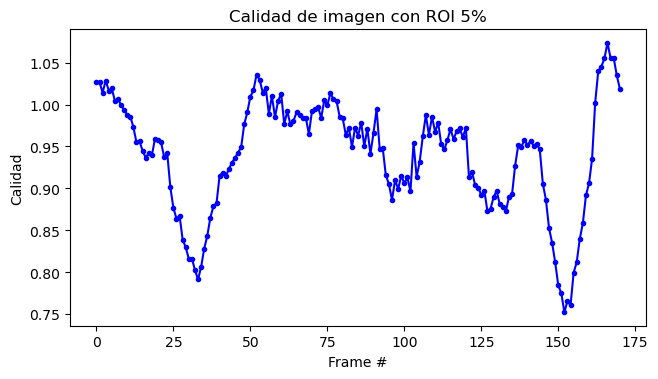

In [68]:
#Con ROI de 5%
frame_roi_5, alto_roi_5, ancho_roi_5 = roi_ls(5)
FM_frames_roi_5 = sharpness_measure(frame_roi_5, alto_roi_5, ancho_roi_5)
FM_scatter_plot(FM_frames_roi_5, 'Calidad de imagen con ROI 5%')


In [69]:
#Creamos video para roi 5%
frames_video_roi_5 = gen_frames_video(FM_frames_roi_5, frame_roi_5[0].shape[0], frame_roi_5[0].shape[1],'IQ con ROI 5%')



<function matplotlib.pyplot.show(close=None, block=None)>

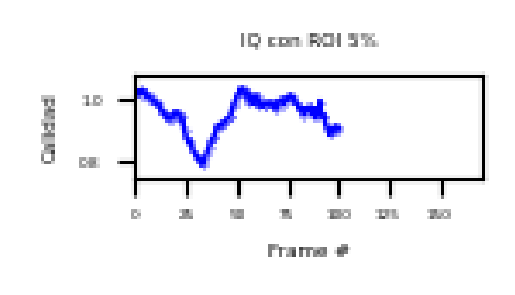

In [70]:
plt.imshow(frames_video_roi_5[100])
plt.axis('off')
plt.show

In [71]:
print('alto_roi_5:', alto_roi_5)
print('ancho_roi_5:', ancho_roi_5)
print('frames_roi_5.shape: ', frame_roi_5[0].shape)
print('frames_video_roi_5.shape: ', frames_video_roi_5[0].shape)

alto_roi_5: 81
ancho_roi_5: 144
frames_roi_5.shape:  (80, 144, 3)
frames_video_roi_5.shape:  (80, 144, 3)


In [72]:
frames_para_video_roi_5 = concatenar_imagenes(frame_roi_5, frames_video_roi_5)
crear_video (frames_para_video_roi_5, frame_roi_5[0].shape[0] , frame_roi_5[0].shape[1]*2,'video_roi_5')

#### ROI 10%

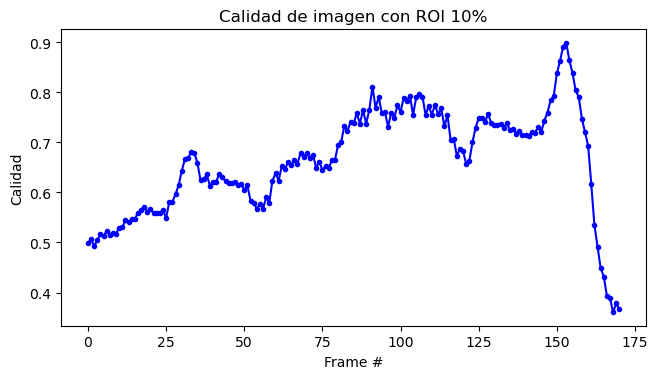

In [73]:
#Con ROI de 10%
frame_roi_10, alto_roi_10, ancho_roi_10 = roi_ls(10)
FM_frames_roi_10 = sharpness_measure(frame_roi_10, alto_roi_10, ancho_roi_10)
FM_scatter_plot(FM_frames_roi_10, 'Calidad de imagen con ROI 10%')

In [74]:
#Creamos video para roi 10%
frames_video_roi_10 = gen_frames_video(FM_frames_roi_10, frame_roi_10[0].shape[0], frame_roi_10[0].shape[1],'IQ con ROI 10%')

<function matplotlib.pyplot.show(close=None, block=None)>

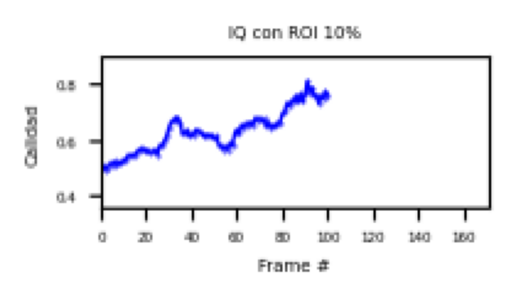

In [75]:
plt.imshow(frames_video_roi_10[100])
plt.axis('off')
plt.show

In [76]:
print('alto_roi_10:', alto_roi_10)
print('ancho_roi_10:', ancho_roi_10)
print('frames_roi_10.shape: ', frame_roi_10[0].shape)
print('frames_video_roi_10.shape: ', frames_video_roi_10[0].shape)

alto_roi_10: 115
ancho_roi_10: 203
frames_roi_10.shape:  (114, 202, 3)
frames_video_roi_10.shape:  (114, 202, 3)


In [77]:
frames_para_video_roi_10 = concatenar_imagenes(frame_roi_10, frames_video_roi_10)

In [78]:
crear_video (frames_para_video_roi_10, frame_roi_10[0].shape[0] , frame_roi_10[0].shape[1]*2,'video_roi_10')

#### ROI 20%

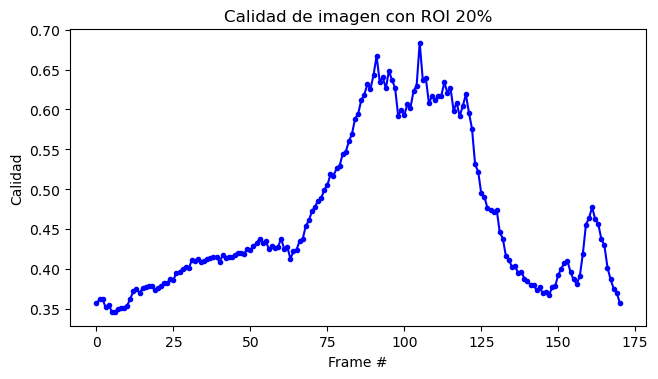

In [79]:
#Con ROI de 20%
frame_roi_20, alto_roi_20, ancho_roi_20 = roi_ls(20)
FM_frames_roi_20 = sharpness_measure(frame_roi_20, alto_roi_20, ancho_roi_20)
FM_scatter_plot(FM_frames_roi_20, 'Calidad de imagen con ROI 20%')

In [80]:
#frames_video_roi_20 = gen_frames_video(FM_frames_roi_20, alto_roi_20, ancho_roi_20,'Calidad de imagen con ROI 20%')
frames_video_roi_20 = gen_frames_video(FM_frames_roi_20, frame_roi_20[0].shape[0], frame_roi_20[0].shape[1],'IQ con ROI 20%')

In [81]:
print('frames_roi_20.shape: ', frame_roi_20[0].shape)
print('frames_video_roi_20.shape: ', frames_video_roi_20[0].shape)

frames_roi_20.shape:  (162, 286, 3)
frames_video_roi_20.shape:  (162, 286, 3)


In [82]:
frames_para_video_roi_20 = concatenar_imagenes(frame_roi_20, frames_video_roi_20)
crear_video (frames_para_video_roi_20, frame_roi_20[0].shape[0] , frame_roi_20[0].shape[1]*2,'video_roi_20')

#### ROI 50%

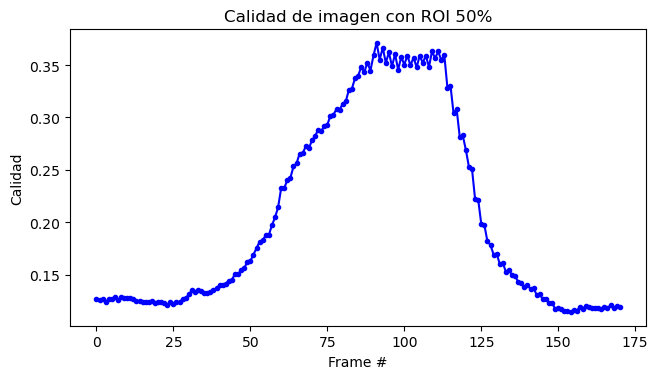

In [83]:
#Con ROI de 50%
frame_roi_50, alto_roi_50, ancho_roi_50 = roi_ls(50)
FM_frames_roi_50 = sharpness_measure(frame_roi_50, alto_roi_50, ancho_roi_50)
FM_scatter_plot(FM_frames_roi_50, 'Calidad de imagen con ROI 50%')

In [84]:
frames_video_roi_50 = gen_frames_video(FM_frames_roi_50, frame_roi_50[0].shape[0], frame_roi_50[0].shape[1],'IQ con ROI 50%')


In [85]:
frames_para_video_roi_50 = concatenar_imagenes(frame_roi_50, frames_video_roi_50)
crear_video (frames_para_video_roi_50, frame_roi_50[0].shape[0] , frame_roi_50[0].shape[1]*2,'video_roi_50')

In [86]:
print('frames_roi_50.shape: ', frame_roi_50[0].shape)
print('frames_video_roi_50.shape: ', frames_video_roi_50[0].shape)

frames_roi_50.shape:  (254, 452, 3)
frames_video_roi_50.shape:  (254, 452, 3)


In [87]:
#Para plotear las ROI
#for i in range(5): #frame_roi_ls:
    #print(frame_roi_ls[i].shape)
    #plt.imshow(frame_roi_ls[i])  # Muestra el frame
    #plt.axis('off')    # Opcional, oculta los ejes
    #plt.show()         # Muestra la imagen en pantalla
    #time.sleep(0.1)    # Pausa para simular el cambio de frame, 0.1 segundos por ejemplo
    #plt.clf()          # Limpia la figura para el siguiente frame
    

### **1.3 Matriz de enfoque**

In [88]:
# Función para generar una matriz de colores basada en el enfoque
def matriz_enf(img, N, M, color, dim, grosor):
    
    alto_img=img.shape[0]
    ancho_img=img.shape[1]
    
    alto_centro_img=alto_img//2
    ancho_centro_img=ancho_img//2

    ancho_enf=(2*M-1)*dim
    alto_enf=(2*N-1)*dim
    
    x_inicial = ancho_centro_img - (ancho_enf//2)
    y_inicial = alto_centro_img - (alto_enf//2)
    
    for i in range(M):
        for j in range(N):
            bbox_start=(x_inicial+(i*(2*dim)),y_inicial+(j*(2*dim)))
            bbox_end = ((x_inicial+dim)+(i*(2*dim)),(y_inicial+dim)+(j*(2*dim)))            
            cv.rectangle(img, bbox_start, bbox_end, color,grosor)
    return img

In [92]:
#Función para definir el color de la matriz
def gen_color_matriz(valor, minimo, maximo):

    # Normalizamos el valor entre minimo y maximo
    valor_normalizado = (valor - minimo) / (maximo - minimo)
    
    # Aseguramos que el valor esté entre 0 y 1
    valor_normalizado = max(0, min(1, valor_normalizado))
    
    # Interpolamos entre rojo (0, 0, 255) y verde (0, 255, 0)
    rojo = int((1 - valor_normalizado) * 255)  # Disminuye de 255 a 0
    verde = int(valor_normalizado * 255)       # Aumenta de 0 a 255
    azul = 0  # Siempre azul es 0 en este caso (ya que estamos interpolando entre rojo y verde)
    
    return (rojo, verde, azul)  # Formato RGB para OpenCV

In [113]:
#Creamos el arreglo con el color de la matriz para cada frame
color_enfoque_ls=[]
min_FM_frames=np.min(FM_frames_ls)
max_FM_frames=np.max(FM_frames_ls)

for i in range(cantidad_frames):
    color=gen_color_matriz(FM_frames_ls[i],min_FM_frames,max_FM_frames)
    color_enfoque_ls.append(color)


In [119]:
#Función para crear vídeo
def crear_video_matriz (filas,columnas,frames_copy=[]):
    frames_copy=copy.deepcopy(frames_for_matriz_ls)
    frames_matriz=[]
    for i in range (cantidad_frames):
        frame_mx=matriz_enf(frames_copy[i], filas, columnas, color_enfoque_ls[i], 10, 2)
        frames_matriz.append(frame_mx)

    #Crear video con los frames 
    output_video = cv.VideoWriter(f'video_matriz_{filas}x{columnas}.mov', cv.VideoWriter_fourcc(*'AVC1'), fps_frames, (frame_ancho, frame_alto))
    # Escribir cada frame en el video
    for frame in frames_matriz:
        frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        output_video.write(frame)
    frames_copy.clear()
    frames_matriz.clear()
    output_video.release()
    return



#### Vídeo de 5x5

In [116]:
crear_video_matriz (5,5)

#### Vídeo de 3x8

In [117]:
crear_video_matriz (3,8)

#### Vídeo de 6x5

In [122]:
crear_video_matriz (6,5)

## **Parte 2**

### **Enunciado y codificación de funciones**

>Cambiar la métrica de enfoque eligiendo uno de los algoritmos explicados en el apéndice de: Analysis of focus measure operators in shapefrom focus.
>
>El algoritmo de detección a implementar debe detectar y devolver los puntos de máximo enfoque de manera automática.

El Gradient Energy (GRA2) es otra medida de enfoque que se basa en la energía del gradiente de la imagen. Esta técnica mide cómo varían las intensidades de los píxeles en las direcciones x e y, lo cual es útil para determinar el enfoque de una imagen.

**Calculo de la primera derivada horizontal y vertical**

Primera derivada horizontal: Se calcula restando la columna actual de la siguiente.

Primera derivada vertical: Se calcula restando la fila actual de la siguiente.

In [138]:
gradient_energy=[]

for frame in frames_ls:
    # Calcular las derivadas
    I_x = np.zeros_like(frame)
    I_x[:, :-1, :] = frame[:, 1:, :] - frame[:, :-1, :]

    I_y = np.zeros_like(frame)
    I_y[:-1, :, :] = frame[1:, :, :] - frame[:-1, :, :]

    # Calcular la energía del gradiente
    gradient_energy_value = np.sum(I_x**2 + I_y**2, axis=(0, 1))
    gradient_energy.append(gradient_energy_value)

Significado de los elementos:

Primer elemento (Canal 0):
Representa la energía del gradiente en el canal rojo (R). Un valor más alto indica un mayor cambio en la intensidad del color rojo en esa área de la imagen.

Segundo elemento (Canal 1):
Representa la energía del gradiente en el canal verde (G). Al igual que el canal rojo, un valor más alto indica un mayor cambio en la intensidad del color verde.

Tercer elemento (Canal 2):
Representa la energía del gradiente en el canal azul (B). Este valor indica el cambio en la intensidad del color azul en esa área.

In [174]:
# Crear tres listas para cada canal RGB
gradient_energy_r = np.array([ge[0] for ge in gradient_energy])
gradient_energy_g = np.array([ge[1] for ge in gradient_energy])
gradient_energy_b = np.array([ge[2] for ge in gradient_energy])

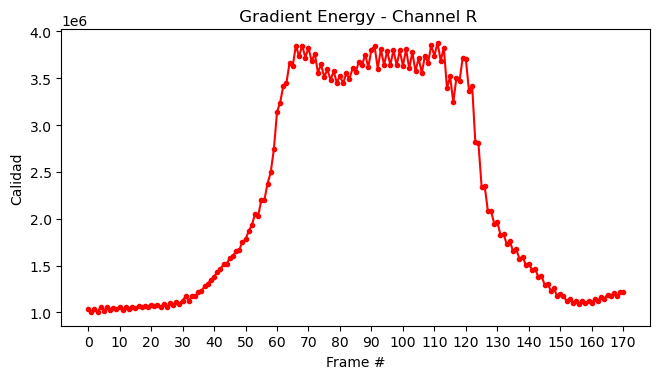

In [213]:
FM_scatter_plot(gradient_energy_r,title= ' Gradient Energy - Channel R', color = 'r')

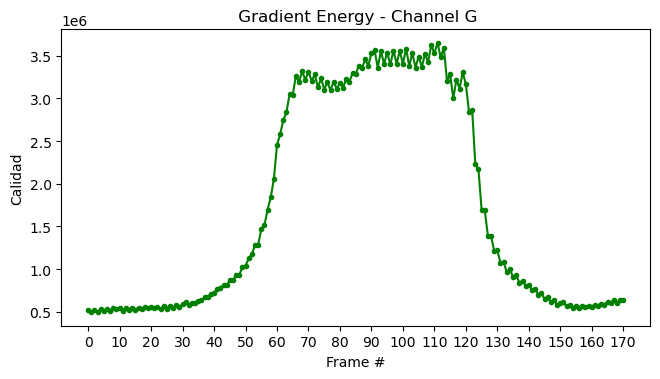

In [211]:
FM_scatter_plot(gradient_energy_g,title= ' Gradient Energy - Channel G', color = 'g')

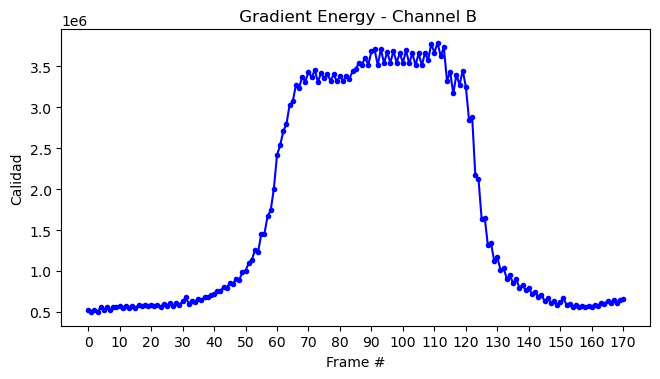

In [210]:
FM_scatter_plot(gradient_energy_b, title= ' Gradient Energy - Channel B', color='b')

Vamos a obtener la raíz cuadrada de la suma de cuadrados de cada canal, para obtener un solo valor. 

In [163]:
sqrt_suma_energy = []

for energy in gradient_energy:
    sum=0
    for i in range(0,3):    #for para recorrer los arrays contenidos en gradient_energy
        sum += energy[i]**2
    sqrt_suma_energy.append(np.sqrt(sum))

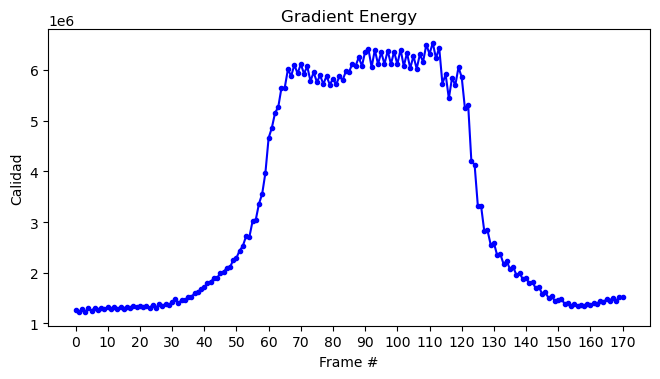

In [197]:
#Ploteo el resultado para cada frame
FM_scatter_plot(sqrt_suma_energy, 'Gradient Energy')

In [203]:
#Frame de mínimo enfoque
idx_min_enfoque=np.argmin(sqrt_suma_energy)
valor_min_enfoque=np.min(sqrt_suma_energy)

#Frame de máximo enfoque
idx_max_enfoque=np.argmax(sqrt_suma_energy)
valor_max_enfoque=np.max(sqrt_suma_energy)

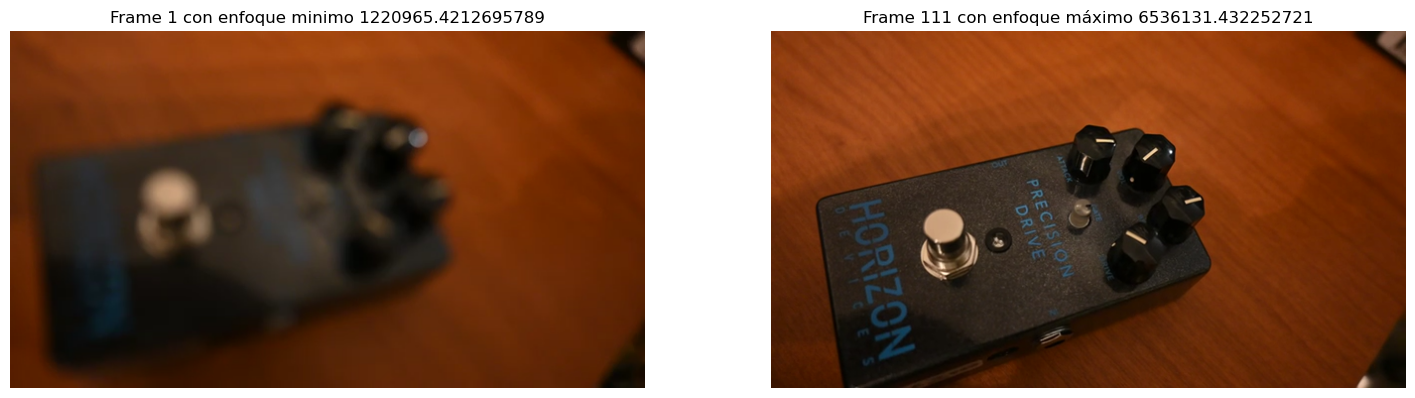

In [206]:
plt.figure(figsize=(18, 12))

plt.subplot(1, 2, 1)
plt.imshow(frames_ls[idx_min_enfoque])
plt.title(f'Frame {idx_min_enfoque} con enfoque minimo {valor_min_enfoque}')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(frames_ls[idx_max_enfoque])
plt.title(f'Frame {idx_max_enfoque} con enfoque máximo {valor_max_enfoque}')
plt.axis('off')

plt.show()

## **Extra: Unsharp Masking**

Tenemos los frames originales y su medida de enfoque:

Frames originales en: frames_ls

Medida de calidad de imagen en: FM_frames_ls

In [42]:
def filtro_gaussiano (kernel = (7,7),sigma = 0.5):
    #Aplicamos el filtro sobre cada uno de nuestro frames 
    #frame_um=frames_for_um
    frame_unsharp_masking=[]
    for frame in frames_ls: 
        gauss = cv.GaussianBlur(frame, kernel, sigma)
        # Aplicar la máscara de enfoque: 
        img_sharp = cv.addWeighted(frame, 2, gauss, -1, 0)
        frame_unsharp_masking.append(img_sharp)

    frames_um = copy.deepcopy(frame_unsharp_masking)
    frame_unsharp_masking.clear()

    return frames_um

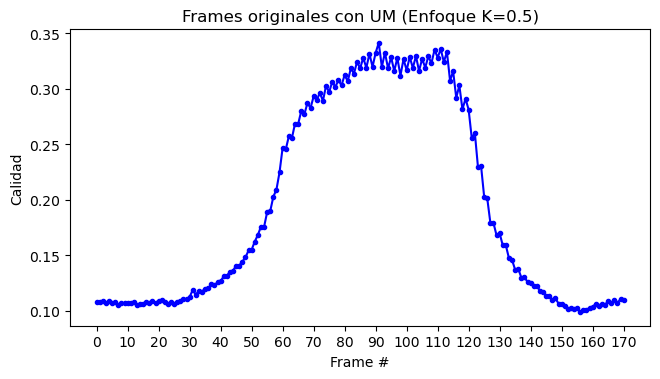

In [50]:
frames_um_05 = filtro_gaussiano()
FM_frames_um_05 = sharpness_measure(frames_um_05, frame_alto, frame_ancho)
FM_scatter_plot(FM_frames_um_05,'Frames originales con UM (Enfoque K=0.5)')
print(f'Máximo enfoque en: frame {np.argmax(FM_frames_um_05)} con {np.max(FM_frames_um_05)}')

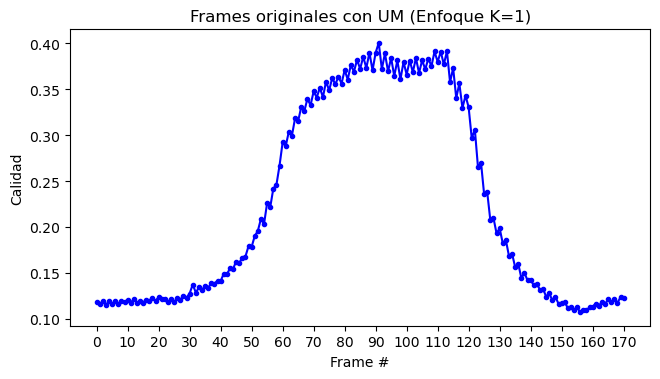

In [49]:
frames_um_1 = filtro_gaussiano(sigma=1)
FM_frames_um_1 = sharpness_measure(frames_um_1, frame_alto, frame_ancho)
FM_scatter_plot(FM_frames_um_1,'Frames originales con UM (Enfoque K=1)')
print(f'Máximo enfoque en: frame {np.argmax(FM_frames_um_1)} con {np.max(FM_frames_um_1)}')

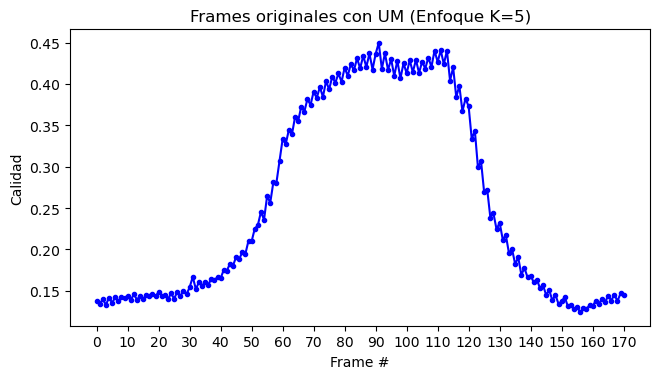

In [51]:
frames_um_5 = filtro_gaussiano(sigma=5)
FM_frames_um_5 = sharpness_measure(frames_um_5, frame_alto, frame_ancho)
FM_scatter_plot(FM_frames_um_5,'Frames originales con UM (Enfoque K=5)')
print(f'Máximo enfoque en: frame {np.argmax(FM_frames_um_5)} con {np.max(FM_frames_um_5)}')

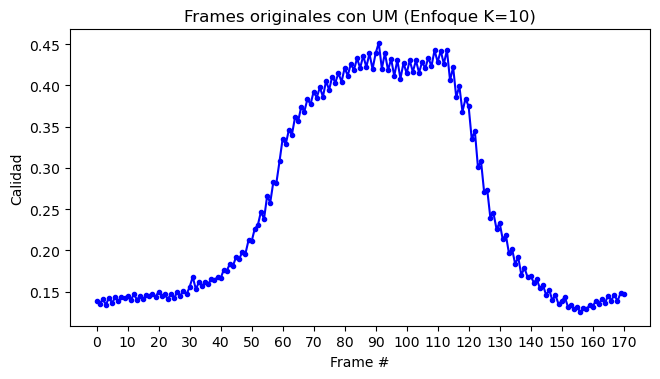

In [52]:
frames_um_10 = filtro_gaussiano(sigma=10)
FM_frames_um_10 = sharpness_measure(frames_um_10, frame_alto, frame_ancho)
FM_scatter_plot(FM_frames_um_10,'Frames originales con UM (Enfoque K=10)')
print(f'Máximo enfoque en: frame {np.argmax(FM_frames_um_10)} con {np.max(FM_frames_um_10)}')

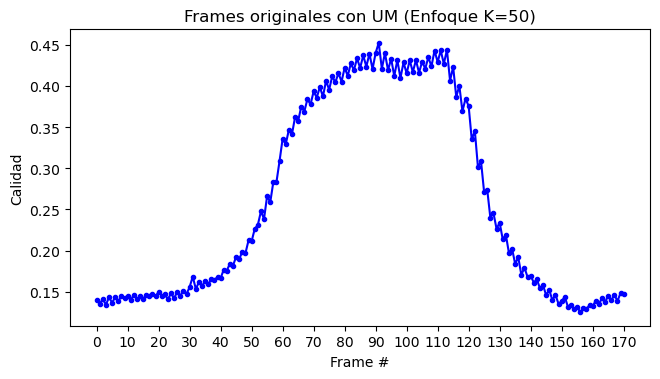

Máximo enfoque en: frame 91 con 0.4521267361111111


In [58]:
frames_um_50 = filtro_gaussiano(sigma=50)
FM_frames_um_50 = sharpness_measure(frames_um_50, frame_alto, frame_ancho)
FM_scatter_plot(FM_frames_um_50,'Frames originales con UM (Enfoque K=50)')
print(f'Máximo enfoque en: frame {np.argmax(FM_frames_um_50)} con {np.max(FM_frames_um_50)}')

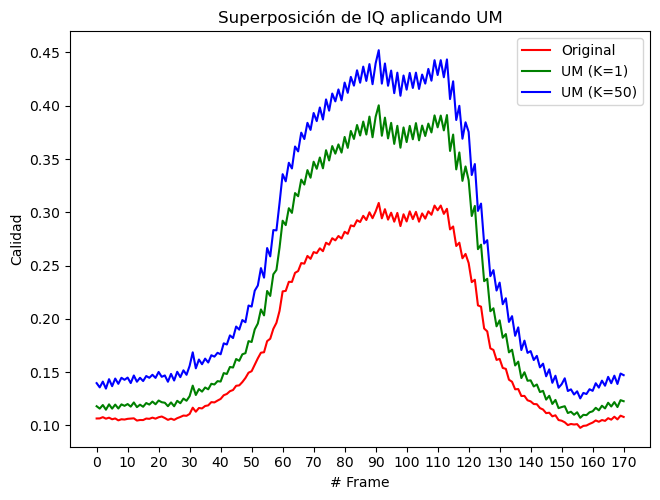

In [70]:
#Frames originales en: frames_ls
#Medida de calidad de imagen en: FM_frames_ls

plt.plot(list(range(len(frames_ls))), FM_frames_ls ,label='Original', color='r')#,marker='.', linestyle='-')  # Gráfico 1 en rojo
plt.plot(list(range(len(frames_ls))), FM_frames_um_1, label='UM (K=1)', color='g')##,marker='.', linestyle='-')  # Gráfico 2 en verde
plt.plot(list(range(len(frames_ls))), FM_frames_um_50, label='UM (K=50)', color='b')#,marker='.', linestyle='-')  # Gráfico 3 en azul

# Añadir etiquetas y leyenda
plt.xlabel('# Frame')
plt.ylabel('Calidad')
plt.title('Superposición de IQ aplicando UM')
plt.xticks(np.arange(0, len(frames_ls), step=10))

plt.legend()
plt.tight_layout(pad=0)

# Mostrar el gráfico
plt.show()

Usando la métrica del paper mencionado en la Parte 1, podemos observar que aplicando un UnsharpMasking con sigma igual a 1 (K=1) ya podemos notar una diferencia sobre los frames originales. Y con un sigma igual a 50 la diferencia es aún más notable, pero, veamos en un vídeo como varia la calidad de imagen. 

In [127]:
#Función para insertar texto sobre frames:

def  insertar_valor (frames_ls,frames_value,color_ls,text_1):
    for i in range(cantidad_frames):
        cv.putText(frames_ls[i],text_1, (450,320), cv.FONT_HERSHEY_SIMPLEX, 0.75, color_ls[i], 2, cv.LINE_AA)
        cv.putText(frames_ls[i],f'IQ={round(frames_value[i],3)}', (450,350), cv.FONT_HERSHEY_SIMPLEX, 0.75, color_ls[i], 2, cv.LINE_AA)
    return frames_ls


### Para K = 1 

In [128]:
#Creamos el arreglo con el color de la matriz para cada frame
color_enfoque_ls_1=[]
for i in range(cantidad_frames):
    color=gen_color_matriz(FM_frames_um_1[i],np.min(FM_frames_um_1),np.max(FM_frames_um_1))
    color_enfoque_ls_1.append(color)

In [129]:
frames_1_video = copy.deepcopy(frames_um_1)
frames_1_para_video = insertar_valor (frames_1_video,FM_frames_um_1,color_enfoque_ls_1,'UM (K=1)')


### Para K = 50

In [130]:
#Creamos el arreglo con el color de la matriz para cada frame
color_enfoque_ls_50=[]
for i in range(cantidad_frames):
    color=gen_color_matriz(FM_frames_um_50[i],np.min(FM_frames_um_50),np.max(FM_frames_um_50))
    color_enfoque_ls_50.append(color)


In [131]:
frames_50_video = copy.deepcopy(frames_um_50)
frames_50_para_video = insertar_valor (frames_50_video,FM_frames_um_50,color_enfoque_ls_50,'UM (K=50)')

### PARA FRAMES ORIGINALES

In [115]:
frames_original_video = copy.deepcopy(frames_ls)
frames_originales_para_video = insertar_valor (frames_original_video,FM_frames_ls,color_enfoque_ls,'Original')

Armamos los frames para los vídeos:

In [122]:
#VAMOS CONCATENAR TODAS LAS IMAGENES 
concatenado_org_1 = concatenar_imagenes (frames_originales_para_video,frames_1_para_video)
concatenado_org_50 = concatenar_imagenes (frames_originales_para_video,frames_50_para_video)
concatenado_total = concatenar_imagenes (concatenado_org_1,frames_50_para_video)


Creamos los vídeos

In [124]:
crear_video (concatenado_org_1, concatenado_org_1[0].shape[0], concatenado_org_1[0].shape[1],'Original_vs_UM_1')

In [125]:
crear_video (concatenado_org_50, concatenado_org_50[0].shape[0], concatenado_org_50[0].shape[1],'Original_vs_UM_50')

In [126]:
crear_video (concatenado_total, concatenado_total[0].shape[0], concatenado_total[0].shape[1],'Original_vs_UM')